In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

In [26]:
import numpy as np
from shapely.geometry import LineString
from shapely.ops import unary_union

line = LineString(([0, 0], [2, 1], [3, 2], [3.5, 1], [5, 2]))
x = [1.0, 4.0, 8.0, -3.0]
y = [0.0, -5.0, -5.0, -9.0]

line = LineString(([x[i],y[i]] for i in range(len(x))))
        
distance_delta = 0.5
distances = np.arange(0, line.length, distance_delta)
points = [line.interpolate(distance) for distance in distances] + [line.boundary[1]]
multipoint = unary_union(points)

print(points[0].x)

1.0


/tmp/ipykernel_151185/2116741501.py:13: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  points = [line.interpolate(distance) for distance in distances] + [line.boundary[1]]


In [2]:
def read_data(filepath):
    training_data = pd.read_csv(filepath)
    training_data_array = training_data.to_numpy()
    X = np.stack((training_data_array[:, 0], training_data_array[:, 1]), axis=-1)
    y1 = training_data_array[:, 2]
    y2 = training_data_array[:, 3]
    return X, y1, y2

In [3]:
def plot_input_data(X, y1, y2, title):
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(18.5, 10.5)
    axs[0, 0].remove()
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], y1)
    axs[0, 1].plot(X[:,0], y1, 'r*')
    axs[0, 1].set_xlabel("x-direction[m]")
    axs[0, 1].set_ylabel("force in x-direction [m/s^2]")
    axs[0, 2].plot(X[:,1], y1, 'g*')
    axs[0, 2].set_xlabel("y-direction[m]")
    axs[0, 2].set_ylabel("force in x-direction [m/s^2]")
    axs[1, 0].remove()
    ax4 = fig.add_subplot(2, 3, 4, projection='3d')
    ax4.scatter(X[:, 0], X[:, 1], y2)
    axs[1, 1].plot(X[:, 0], y2, 'r*')
    axs[1, 1].set_xlabel("x-direction[m]")
    axs[1, 1].set_ylabel("force in y-direction [m/s^2]")
    axs[1, 2].plot(X[:, 1], y2, 'g*')
    axs[1, 2].set_xlabel("y-direction[m]")
    axs[1, 2].set_ylabel("force in y-direction [m/s^2]")
    fig.suptitle(title)
    plt.show()

In [4]:
def plot_wind_field(X, y1, y2, title, res):
    fig, ax = plt.subplots(1, 1)
    plt.axis('equal')
    plt.grid(linestyle=':')
    try:
        q = plt.quiver(X.numpy()[::res, 0], X.numpy()[::res, 1], y1.numpy()[::res], y2.numpy()[::res], scale=2.54, color='r',
                       units='width', scale_units="inches", width=0.003)
    except:
        q = plt.quiver(X[::res, 0], X[::res, 1], y1[::res], y2[::res], scale=2.54*2, color='r',
                       units='width', scale_units="inches", width=0.003)
    plt.title(title)
    plt.ioff()
    plt.show()

In [5]:
def create_grid(start, stop, res):
    x = np.linspace(start, stop, res)
    y = np.linspace(start, stop, res)
    x, y = np.meshgrid(x, y)
    X = np.stack((x.flatten(), y.flatten()), axis=-1)
    return X, x, y

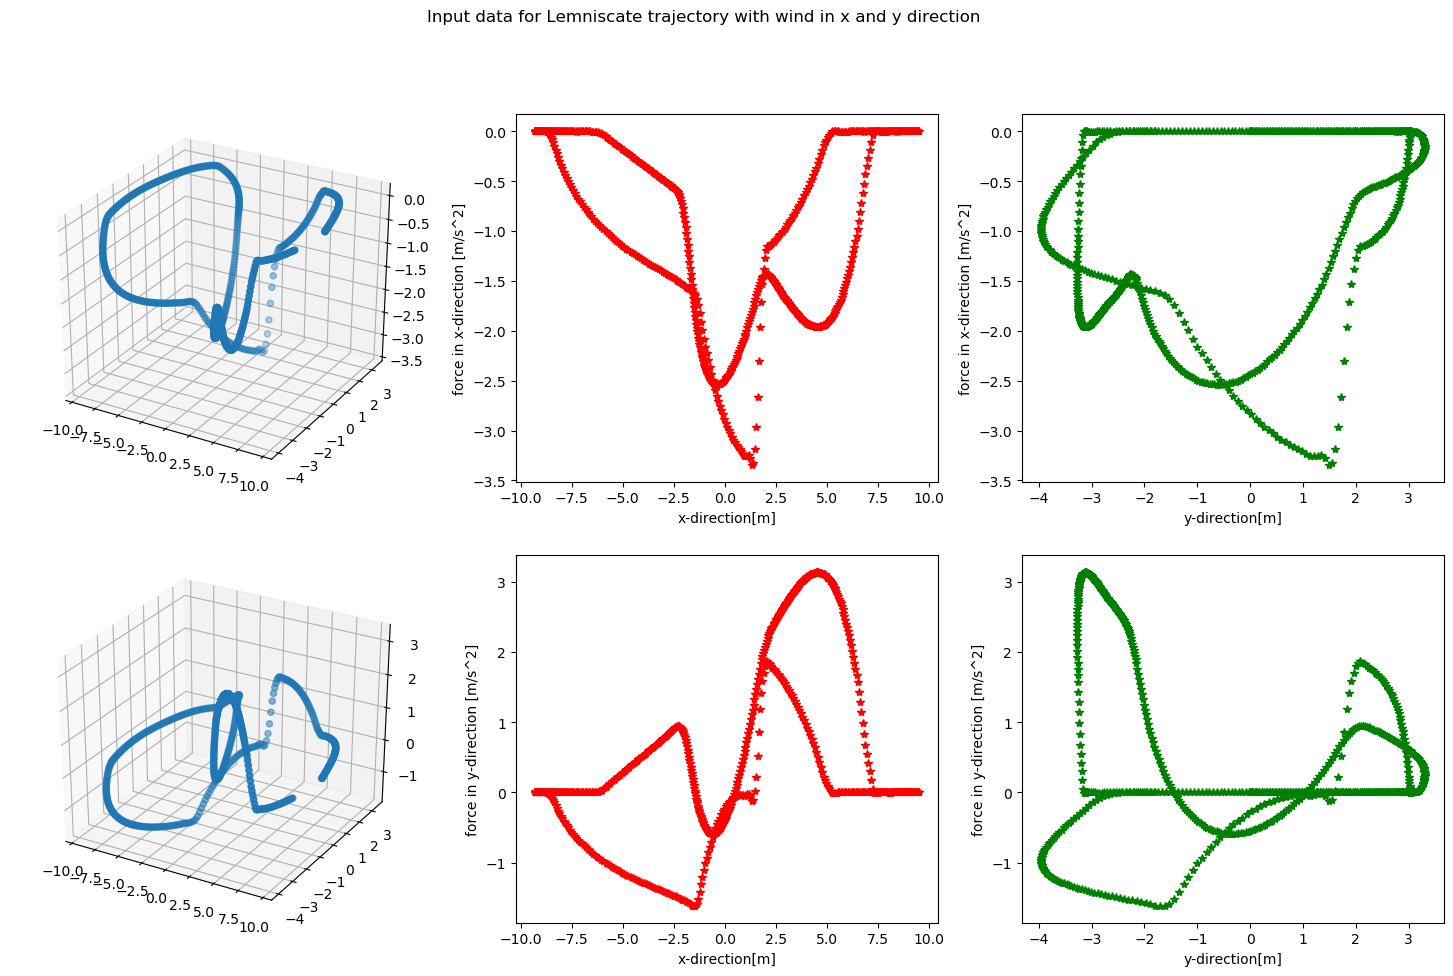

In [6]:
X, y1, y2 = read_data('/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_xy_random_2022-09-07-10-52-31.csv')
plot_input_data(X, y1, y2, "Input data for Lemniscate trajectory with wind in x and y direction")

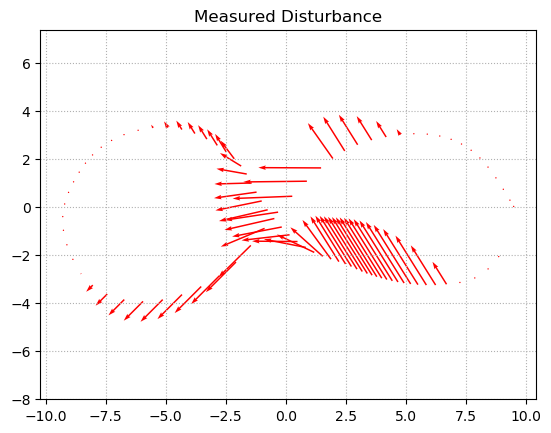

In [7]:
plot_wind_field(X, y1, y2, "Measured Disturbance",8)

In [22]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=1)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=1)

## Training in Sklearn


In [23]:
print(X_train.shape, y1_train.shape)

(586, 2) (586,)


In [30]:
# Define the prior and model and fit the GP
kernel = 0.5**2 * RBF(length_scale=[5, 1])
gaussian_process1 = GaussianProcessRegressor(kernel=kernel, alpha=0.001, n_restarts_optimizer=10)
gaussian_process1.fit(X_train, y1_train)
gaussian_process1.kernel_

0.887**2 * RBF(length_scale=[1.23, 0.455])

In [31]:
# Define the prior and model and fit the GP
kernel = 0.5**2 * RBF(length_scale=[5, 1])
gaussian_process2 = GaussianProcessRegressor(kernel=kernel, alpha=0.001, n_restarts_optimizer=10)
gaussian_process2.fit(X_train, y2_train)
gaussian_process2.kernel_

0.753**2 * RBF(length_scale=[0.906, 0.482])

In [32]:
X_grid, x_grid, y_grid = create_grid(-10,9.9,51)

In [33]:
# Prediction 
mean_pred1, std_pred = gaussian_process1.predict(X_grid, return_std=True)

In [34]:
# Prediction 
mean_pred2, std_pred = gaussian_process2.predict(X_grid, return_std=True)

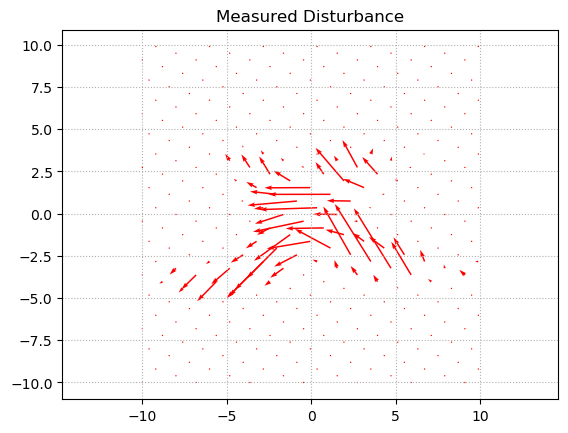

In [35]:
plot_wind_field(X_grid, mean_pred1, mean_pred2, "Measured Disturbance",8)

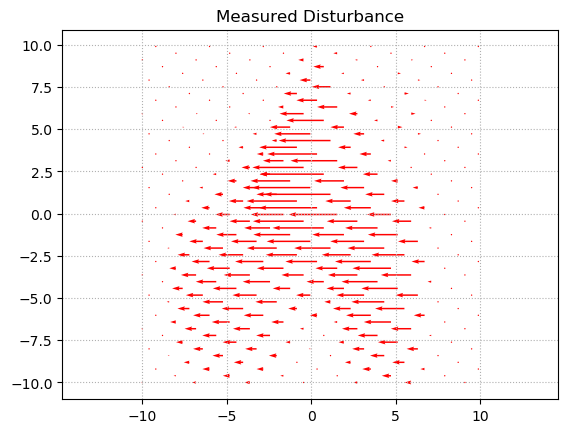

In [16]:
plot_wind_field(X_grid, mean_pred1, np.zeros(mean_pred1.size), "Measured Disturbance",8)

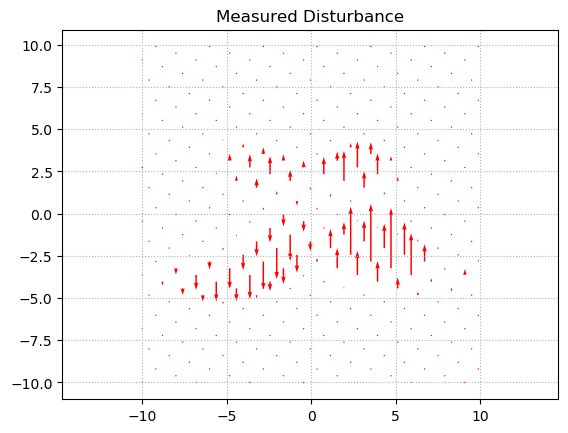

In [17]:
plot_wind_field(X_grid, np.zeros(mean_pred1.size), mean_pred2, "Measured Disturbance",8)

In [18]:
kernel = 1.14**2 * RBF(length_scale=[6.21, 0.709])


In [19]:
X_train = np.linspace(-10, 10, 51).reshape(-1, 1)
y_train = np.sin(X_train)

In [20]:
X_train = X_train[:,1]
X_train = X_train.reshape(-1,1)
y_train = y1_train.reshape(-1,1)
X_test = X_test[:,1]
X_test = X_test.reshape(-1,1)
y_test = y1_test.reshape(-1,1)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
#plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train[:,0], y1_train, label="Observations")
plt.plot(X_grid[:,0], mean_pred, label="Mean prediction")
# plt.fill_between(
#     X_test.ravel(),
#     mean_pred - 1.96 * std_pred,
#     mean_pred + 1.96 * std_pred,
#     alpha=0.5,
#     label=r"95% confidence interval",
# )
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")
plt.show()